In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema

import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:5'

FREERUN = 20  # Extra predicition time-steps after test data
deltaT = .02      # Number of extra free-running steps  int(20/.02) 

rho = 28.0
sigma = 10.0
beta = 8/3

# Lorenz 1963
def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]             # Initial point
t = np.arange(0,300+FREERUN,deltaT)  # Total of 320 full steps with deltaT=.02
states = odeint(f,state0,t)

mu = np.mean(states, axis=0)       # Get mean for each of x,y,z
signal = (states - mu)[:,[0,1,2]]  # Mean center the data
M = signal.shape[0] - int(FREERUN/deltaT)  # Length of train plus test... no freerun
K = 3                                  # Input dimension
L = 3                                  # Output dimension
RF = .5                                # For feedback <--- not implemented
TEST = 1000                            # length of test
LEAD = 100                            # Number of points to plot before test
BURNIN = 100                           # Number of steps ignored for random x0 to fade
REG = 1e-8                             # Regularization factor for ridge regression
TRAINLENGTH = M-TEST    

MINMAXS = np.max(signal[:TRAINLENGTH+TEST],axis=0)-np.min(signal[:TRAINLENGTH+TEST],axis=0)
RGS = [(-19.5,19.5),(-27,27),(-25,25)]
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [2]:
np.save('./Targets/L3Dsignal', signal)

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

## Training Loop for gp_minimize

In [4]:
min_a, max_a = .5, .7
min_sr, max_sr = .6, 1.45
min_g, max_g = .9, 1.
min_ri, max_ri = .001, .4
min_rr, max_rr = .9, 1.1
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    # Avoid copying from CPU to GPU    
    # Init container variables directly on GPU
    ut = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE)) 
    tp = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE))
    
    # Init matrices directly on GPU
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1) # Concat to one matrix for faster compute
    xt, yt = set_vectorsGPU(N,L,rr) # On GPU random init x0 and container yt   
    
    # GPU containers for Phi and y in regression solve (bad naming... reused var name)
    # Here states is the Phi matrix
    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                        device=DEVICE)
    # Loop through training data and accumulate states for ridge-regression solve
    for i in range(TRAINLENGTH):
        ut[:,0] = s[i]                         # Forcing u[t] 
        tp[:,0] = s[i+1]                       # True target for prediction u[t+1] 
        uxy = torch.cat((ut,xt,yt),0)          # Concat vectors for use with Wnet
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp) # x[t+1] = F(x[t],u[t])
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE) # Transpose as row for Phi
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy() 
    #target = targets.detach().cpu().numpy()
    
    
    ############################             Ridge Regression solve on CPU (fast!)
    torch.cuda.synchronize()    # GPU threads were running asynchronous
                                # Use signal since already sitting on CPU side
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
                                # Move back to GPU
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE) # Trained Wout
    torch.cuda.synchronize()    # Make sure synchronized before prediction pass
    ############################
    
    # Container for all predictions... Burnin --> train --> test --> freerun
    predictions = torch.zeros((M+int(FREERUN/deltaT),K),
                              dtype=dtype,
                              device=torch.device(DEVICE))
    # Reset new initial vectors for prediction pass
    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/deltaT)):
        if(i < TRAINLENGTH):
            ut[:,0] = s[i]
        else:
            #pdb.set_trace()
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        #pdb.set_trace()
        predictions[i] = yt1[:,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()  # Move predictions onto CPU (numpy)
    
    nrmse = np.ones((K,1))*1000
    try:
        for i in range(K):
            nrmse[i,0] = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   MINMAXS[i])
    except: 
        pass
    #### Pearson Correlation <=> Cosine Distance    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST]
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST])
    dists = np.zeros(K)
    for i in range(K):
        avec = av[:,i].reshape(TEST,1)
        bvec = bv[:,i].reshape(TEST,1)
        num = np.squeeze(np.dot(avec.T,bvec))
        den = np.linalg.norm(avec)*np.linalg.norm(bvec)
        cosine_similarity = num/den
        cosine_distance = 1 - cosine_similarity
        dists[i] = cosine_distance
        
    loss = np.max(nrmse+dists)
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .95)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(15,12))
        plt.subplot(3,1,1)
        plt.plot(signal[TRAINLENGTH-LEAD:,0], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,0], label='X pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,2)
        plt.plot(signal[TRAINLENGTH-LEAD:,1], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,1], label='Y pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(signal[TRAINLENGTH-LEAD:,2], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,2], label='Z pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        plt.show()
        fig.savefig(f'./L3D_Saved_Models/L3D_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {np.max(nrmse):.3f} CD {np.max(dists):.3f}')
    counter += 1
    return loss

## Parameter Search with gp_minimize

********** Size20 ref 0 -- Run 0 ***********
Iter: 0 #### Diagnostic 1.738113   Time 6.72  Best 1000.000 NRMSE 0.322 CD 1.416
Iter: 1 #### Diagnostic 1000.000000   Time 3.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 3.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.395818   Time 3.55  Best 1000.000 NRMSE 0.320 CD 1.076
Iter: 4 #### Diagnostic 1000.000000   Time 3.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 3.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 2.107853   Time 3.55  Best 1000.000 NRMSE 1.083 CD 1.025
Iter: 8 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.408083   Time 3.75  Best 1000.000 NRMSE 0.330 CD 1.078
Iter: 10 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 7671417440030167.000 CD 1.040
Iter: 11 #### Diagnos

Iter: 95 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 155537687379.278 CD 1.022
Iter: 96 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.371745   Time 3.54  Best 1000.000 NRMSE 0.290 CD 1.081
Iter: 99 #### Diagnostic 1.321269   Time 3.55  Best 1000.000 NRMSE 0.295 CD 1.026

Run: 0 Best result = 1.2606873614414216
a = 0.6464174134776097
sr = 0.8113211508810716
amp = 0.9665122596613244
ri = 0.20446142608048648
rr = 1.0221006943844322
********** Size20 ref 0 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 3.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 381916544695379019799259319894016.000

Iter: 87 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.377265   Time 3.56  Best 1000.000 NRMSE 0.305 CD 1.073
Iter: 91 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.267540   Time 3.55  Best 1000.000 NRMSE 0.272 CD 0.996
Iter: 94 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 3.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.243824   Time 3.55  Best 1000.000 N

Iter: 81 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 3.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 3.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.334619   Time 3.61  Best 1000.000 NRMSE 0.309 CD 1.026
Iter: 85 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.236335   Time 3.59  Best 1000.000 NRMSE 0.288 CD 0.948
Iter: 89 #### Diagnostic 1.354294   Time 3.56  Best 1000.000 NRMSE 0.300 CD 1.054
Iter: 90 #### Diagnostic 1000.000000   Time 3.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.258575   Time 3.55  Best 1000.000 NRMSE 0.300 CD 0.958
Iter: 92 #### Diagnostic 1000.000000   Time 3.54  Best 1000.000 NRMSE 

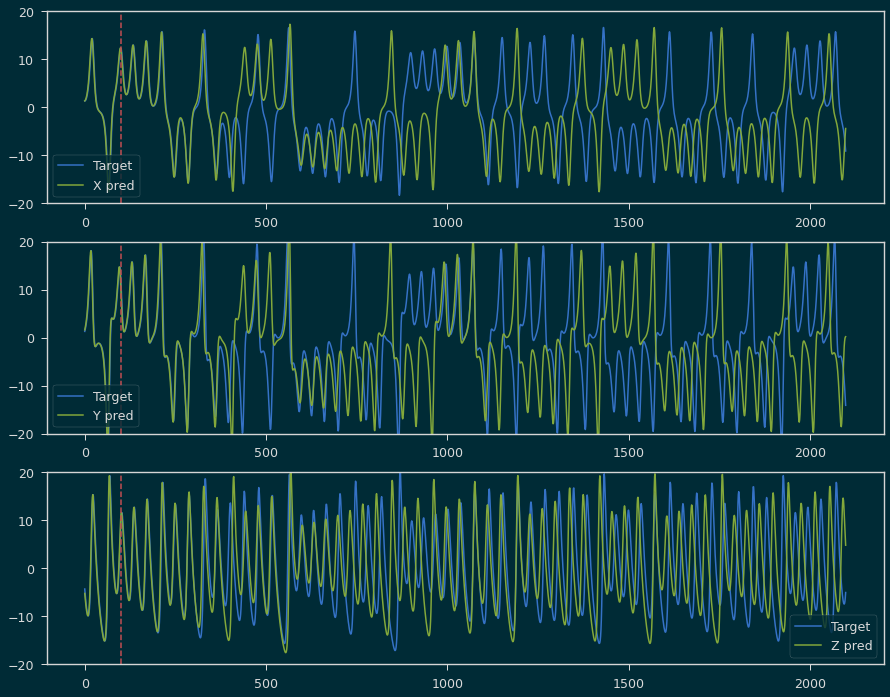

 Iter=68 a=0.683 sr=1.333 amp=0.993  ri=0.014 rr=1.083 loss=0.749168


Iter: 68 #### Diagnostic 0.749168   Time 5.85  Best 0.749 NRMSE 0.207 CD 0.543
Iter: 69 #### Diagnostic 1000.000000   Time 5.00  Best 0.749 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.00  Best 0.749 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.376882   Time 5.00  Best 0.749 NRMSE 0.307 CD 1.069
Iter: 72 #### Diagnostic 1000.000000   Time 5.00  Best 0.749 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.283273   Time 5.01  Best 0.749 NRMSE 0.337 CD 0.947
Iter: 74 #### Diagnostic 1000.000000   Time 5.13  Best 0.749 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.311071   Time 5.01  Best 0.749 NRMSE 0.320 CD 0.991
Iter: 76 #### Diagnostic 1.862986   Time 4.99  Best 0.749 NRMSE 0.880 CD 0.983
Iter: 77 #### Diagnostic 1000.000000   Time 4.99  Best 0.749 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 4.99  Best 0.749 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000

Iter: 63 #### Diagnostic 1000.000000   Time 3.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.546226   Time 3.75  Best 1000.000 NRMSE 0.501 CD 1.045
Iter: 66 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.384789   Time 3.74  Best 1000.000 NRMSE 0.286 CD 1.099
Iter: 68 #### Diagnostic 1.403151   Time 3.73  Best 1000.000 NRMSE 0.331 CD 1.073
Iter: 69 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 2.804744   Time 3.72  Best 1000.000 NRMSE 1.672 CD 1.133
Iter: 72 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 26566467105148821964152897536.000 CD 1.000
Iter: 73 #### Diagnostic 1000.000000   Time 3.69  Best 1000.000 NRMSE 10678523774004515709459682557952.000 CD 1.000
Iter: 74 ####

Iter: 49 #### Diagnostic 1.356453   Time 3.73  Best 1000.000 NRMSE 0.300 CD 1.056
Iter: 50 #### Diagnostic 1000.000000   Time 3.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.462188   Time 3.74  Best 1000.000 NRMSE 0.395 CD 1.068
Iter: 52 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 4321488557862542626521088.000 CD 1.000
Iter: 56 #### Diagnostic 1.325353   Time 3.69  Best 1000.000 NRMSE 0.295 CD 1.030
Iter: 57 #### Diagnostic 1.953359   Time 3.74  Best 1000.000 NRMSE 0.910 CD 1.044
Iter: 58 #### Diagnostic 1.625195   Time 3.73  Best 1000.000 NRMSE 0.613 CD 1.013
Iter: 59 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 34863649338766389304449040384.000 CD 1.000
Iter: 60 #### Diagnostic

Iter: 43 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 56652718322961120258323104223199232.000 CD 1.000
Iter: 45 #### Diagnostic 1000.000000   Time 3.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.431895   Time 3.68  Best 1000.000 NRMSE 0.332 CD 1.100
Iter: 54 #### Diagnostic 

Iter: 36 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.406641   Time 3.69  Best 1000.000 NRMSE 0.322 CD 1.084
Iter: 38 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 3.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 3.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 3.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 3.66  Best 100

Iter: 30 #### Diagnostic 1.250915   Time 3.71  Best 1000.000 NRMSE 0.236 CD 1.015
Iter: 31 #### Diagnostic 1.428172   Time 3.68  Best 1000.000 NRMSE 0.403 CD 1.025
Iter: 32 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 3.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.403821   Time 3.71  Best 1000.000 NRMSE 0.304 CD 1.099
Iter: 38 #### Diagnostic 1.405378   Time 3.71  Best 1000.000 NRMSE 0.337 CD 1.069
Iter: 39 #### Diagnostic 1000.000000   Time 3.69  Best 1000.000 NRMSE 3739728974.541 CD 0.997
Iter: 40 #### Diagnostic 1000.000000   Time 3.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.407763   Time 3.67  Best 1000.000 N

Iter: 24 #### Diagnostic 1.292722   Time 3.93  Best 1000.000 NRMSE 0.275 CD 1.018
Iter: 25 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.458796   Time 3.69  Best 1000.000 NRMSE 0.392 CD 1.066
Iter: 27 #### Diagnostic 2.976572   Time 3.70  Best 1000.000 NRMSE 1.981 CD 0.996
Iter: 28 #### Diagnostic 1000.000000   Time 3.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 3.847569   Time 3.69  Best 1000.000 NRMSE 2.819 CD 1.028
Iter: 31 #### Diagnostic 1.680297   Time 3.94  Best 1000.000 NRMSE 0.651 CD 1.030
Iter: 32 #### Diagnostic 1000.000000   Time 3.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.190795   Time 3.68  Best 1000.000 NRMSE 0.260 CD 0.930
Iter: 35 #### Diagnostic 1000.000000   Time 3.64  Best 1000.000 NRMSE 1000.000

Iter: 14 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.878592   Time 3.65  Best 1000.000 NRMSE 0.786 CD 1.093
Iter: 16 #### Diagnostic 1000.000000   Time 3.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.383103   Time 3.79  Best 1000.000 NRMSE 0.281 CD 1.102
Iter: 21 #### Diagnostic 1000.000000   Time 3.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.93  Best 1000.00

Iter: 7 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 4.793045   Time 3.83  Best 1000.000 NRMSE 3.773 CD 1.020
Iter: 14 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 3.90  Best 1000.0

Iter: 0 #### Diagnostic 1000.000000   Time 3.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 3.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 3.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 3.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1.371387   Time 3.63  Best 1000.000 NRMSE 0.304 CD 1.068
Iter: 9 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMS

Iter: 96 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.220854   Time 3.85  Best 1000.000 NRMSE 0.279 CD 0.942
Iter: 98 #### Diagnostic 1.590349   Time 3.93  Best 1000.000 NRMSE 0.334 CD 1.257
Iter: 99 #### Diagnostic 1.657354   Time 3.80  Best 1000.000 NRMSE 0.474 CD 1.183

Run: 2 Best result = 1.056117102275685
a = 0.5251014636011705
sr = 1.1367664668678374
amp = 0.968162518286487
ri = 0.2589587408795894
rr = 0.9194114628043748
********** Size20 ref 2 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.383488   Time 3.87  Best 1000.000 NRMSE 0.323 CD 1.060
Iter: 3 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.362199   Time 3.8

Iter: 90 #### Diagnostic 1.867026   Time 3.84  Best 1000.000 NRMSE 0.846 CD 1.021
Iter: 91 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.282195   Time 3.82  Best 1000.000 NRMSE 0.309 CD 0.974
Iter: 95 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.156827   Time 3.85  Best 1000.000 NRMSE 0.272 CD 0.885
Iter: 98 #### Diagnostic 1.071580   Time 3.78  Best 1000.000 NRMSE 0.252 CD 0.820
Iter: 99 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan

Run: 3 Best result = 1.0715799582849042
a = 0.6532371133719584
sr = 1.329378600704552
amp = 0.9812693119387991
ri = 0.257602939662124
rr = 1.02284528332312

Iter: 84 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.043336   Time 3.74  Best 1000.000 NRMSE 0.237 CD 0.807
Iter: 92 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.303561   Time 3.83  Best 1000.000 NRMSE 0.334 CD 0.969
Iter: 95 #### Diagnostic 1000.000000   Time 3.89  Best 1000.00

Iter: 75 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 3.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.509117   Time 3.80  Best 1000.000 NRMSE 0.322 CD 1.187
Iter: 80 #### Diagnostic 1000.000000   Time 3.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 44705765952112279552.000 CD 1.000
Iter: 83 #### Diagnostic 2.310539   Time 3.80  Best 1000.000 NRMSE 1.227 CD 1.083
Iter: 84 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 4876202556451620651008.000 CD 1.000
Iter: 85 #### Diagnostic 1.250664   Time 3.81  Best 1000.000 NRMSE 0.285 CD 0.965
Iter: 86 #### Diagnostic 100

Iter: 68 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.308368   Time 3.89  Best 1000.000 NRMSE 0.285 CD 1.023
Iter: 70 #### Diagnostic 1.400368   Time 3.85  Best 1000.000 NRMSE 0.323 CD 1.077
Iter: 71 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.422008   Time 3.98  Best 1000.000 NRMSE 0.303 CD 1.119
Iter: 75 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.324117   Time 3.98  Best 1000.000 NRMSE 0.277 CD 1.047
Iter: 77 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.396888   Time 3.88  Best 1000.000 NRMSE 0.3

Iter: 62 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.357234   Time 3.81  Best 1000.000 NRMSE 0.337 CD 1.021
Iter: 65 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.360085   Time 3.85  Best 1000.000 NRMSE 0.309 CD 1.051
Iter: 70 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.407910   Time 3.79  Best 1000.000 NRMSE 0.314 CD 1.094
Iter: 72 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NR

Iter: 56 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 5800259728558671908694917120.000 CD 1.000
Iter: 67 #### Diagnostic 100

Iter: 49 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.644957   Time 3.84  Best 1000.000 NRMSE 0.623 CD 1.022
Iter: 53 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.425438   Time 3.79  Best 1000.000 NRMSE 0.308 CD 1.118
Iter: 55 #### Diagnostic 4.929992   Time 3.81  Best 1000.000 NRMSE 3.945 CD 0.985
Iter: 56 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.528934   Time 3.79  Best 1000.000 NRMSE 0.376 CD 1.153
Iter: 58 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 3.349331   Time 3.83  Best 1000.000 NRMSE 2.174 CD 1.176
Iter: 60 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000

Iter: 39 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.385132   Time 3.85  Best 1000.000 NRMSE 0.320 CD 1.065
Iter: 47 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.381543   Time 3.82  Best 1000.000 NRMSE 0.318 CD 1.064
Iter: 49 #### Diagnostic 1.478348   Time 3.85  Best 1000.000 NRMSE 0.297 CD 1.181
Iter: 50 #### Diagnostic 1.424221   Time 3.83  Best 1000.000 NRMSE

Iter: 33 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.572115   Time 4.29  Best 1000.000 NRMSE 0.313 CD 1.259
Iter: 43 #### Diagnostic 1.303989   Time 3.95  Best 1000.000 NRMSE 0.295 CD 1.009
Iter: 44 #### Diagnostic 4.079426   Time 3.94  Best 1000.000 N

Iter: 27 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 46742479684872432.000 CD 1.005
Iter: 34 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.429517   Time 3.86  Best 1000.000 NRMSE 0.277 CD 1.152
Iter: 38 #### Diagnostic 1.513361   Time 3.

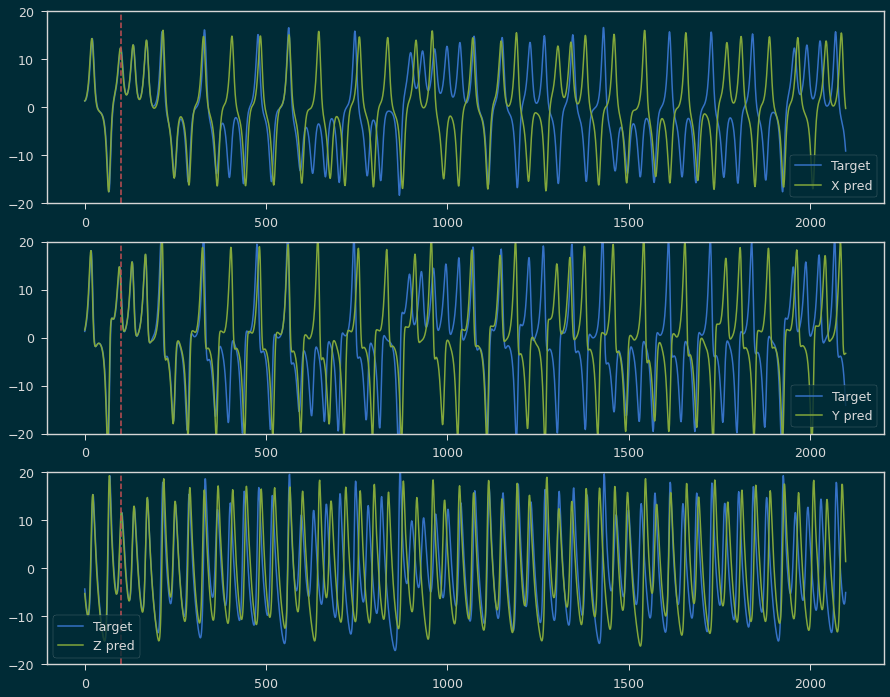

 Iter=16 a=0.565 sr=1.395 amp=0.994  ri=0.034 rr=0.939 loss=0.923443


Iter: 16 #### Diagnostic 0.923443   Time 4.83  Best 0.923 NRMSE 0.224 CD 0.699
Iter: 17 #### Diagnostic 1000.000000   Time 3.85  Best 0.923 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 3.84  Best 0.923 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 3.85  Best 0.923 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 3.83  Best 0.923 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 3.84  Best 0.923 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 3.87  Best 0.923 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 3.94  Best 0.923 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.87  Best 0.923 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.385790   Time 3.83  Best 0.923 NRMSE 0.320 CD 1.066
Iter: 26 #### Diagnostic 1000.000000   Time 3.86  Best 0.923 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic

Iter: 12 #### Diagnostic 1.414073   Time 4.84  Best 1000.000 NRMSE 0.328 CD 1.086
Iter: 13 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.357764   Time 6.09  Best 1000.000 NRMSE 0.326 CD 1.031
Iter: 15 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.449493   Time 5.11  Best 1000.000 NRMSE 0.318 CD 1.131
Iter: 18 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.801898   Time 3.90  Best 1000.000 NRMSE 0.731 CD 1.071
Iter: 21 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 

Iter: 0 #### Diagnostic 1.421629   Time 5.44  Best 1000.000 NRMSE 0.326 CD 1.096
Iter: 1 #### Diagnostic 1.248441   Time 7.31  Best 1000.000 NRMSE 0.285 CD 0.963
Iter: 2 #### Diagnostic 1.380924   Time 5.49  Best 1000.000 NRMSE 0.306 CD 1.075
Iter: 3 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 40999090000944248.000 CD 1.059
Iter: 4 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 140648138879657320674941206528.000 CD 1.000
Iter: 6 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.382589   Time 5.29  Best 1000.000 NRMSE 0.318 CD 1.065
Iter: 10 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 2.628030   T

Iter: 97 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.87  Best 1000.000 NRMSE 1000.000 CD nan

Run: 0 Best result = 1.1565982143128994
a = 0.5828011633320522
sr = 1.1669454560122414
amp = 0.9263186429951588
ri = 0.22917378947030143
rr = 1.0584721303916393
********** Size10 ref 0 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.277609   Time 5.13  Best 1000.000 NRMSE 0.311 CD 0.967
Iter: 2 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 65889976460948340796685738261348352.000 CD 1.000
Iter: 3 #### Diagnostic 1.394870   Time 5.03  Best 1000.000 NRMSE 0.330 CD 1.065
Iter: 4 #### Diagnostic 1.399635   Time 5.80  Best 1000.000 NRMSE 0.290 CD 1.110
Iter: 5 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 91 #### Diagnostic 1.307232   Time 3.83  Best 1000.000 NRMSE 0.285 CD 1.022
Iter: 92 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.314281   Time 3.89  Best 1000.000 NRMSE 0.252 CD 1.063
Iter: 99 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan

Run: 1 Best result = 1.145182372958827
a = 0.589267652126233
sr = 1.3787707093642656
amp = 0.9880708824108986
ri = 0.26908931484363957
rr = 0.9158280018709063
********** Size10 ref 0 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.326

Iter: 86 #### Diagnostic 1.270737   Time 5.22  Best 1000.000 NRMSE 0.277 CD 0.993
Iter: 87 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.234401   Time 6.81  Best 1000.000 NRMSE 0.284 CD 0.950
Iter: 90 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.362127   Time 4.96  Best 1000.000 NRMSE 0.295 CD 1.067
Iter: 93 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.411719   Time 5.41  Best 1000.000 NRMSE 0.327 CD 1.085
Iter: 95 #### Diagnostic 1.193757   Time 5.29  Best 1000.000 NRMSE 0.248 CD 0.945
Iter: 96 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.273447   Time 5.30  Best 1000.000 NRMSE 0.277 C

Iter: 80 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.496223   Time 5.20  Best 1000.000 NRMSE 0.333 CD 1.163
Iter: 83 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 3.106508   Time 5.04  Best 1000.000 NRMSE 2.108 CD 0.998
Iter: 85 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.342559   Time 5.05  Best 1000.000 NRMSE 0.288 CD 1.054
Iter: 87 #### Diagnostic 1.381066   Time 5.30  Best 1000.000 NRMSE 0.310 CD 1.071
Iter: 88 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 

Iter: 74 #### Diagnostic 1.275225   Time 4.84  Best 1000.000 NRMSE 0.316 CD 0.959


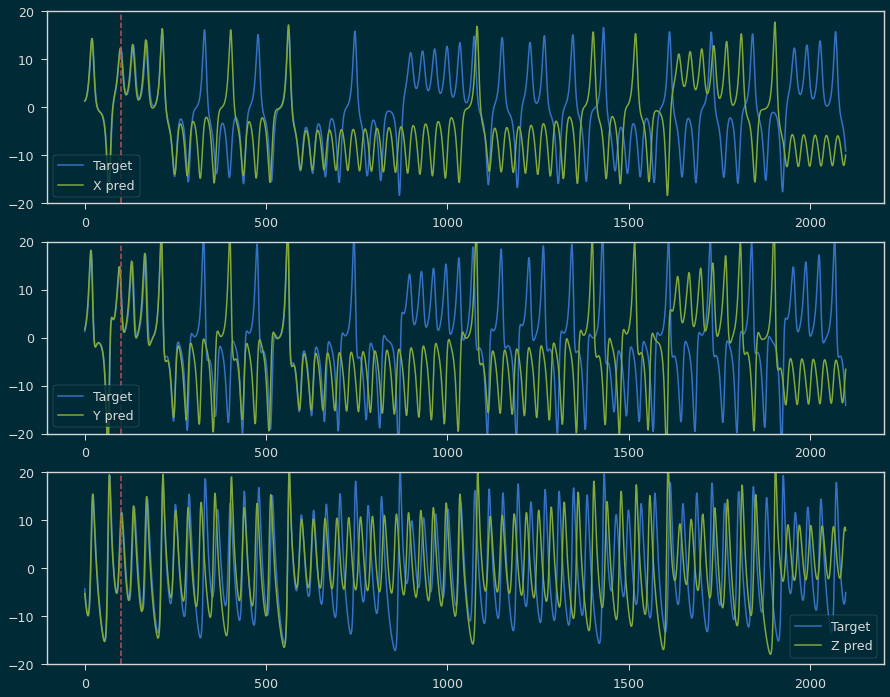

 Iter=75 a=0.617 sr=1.396 amp=0.995  ri=0.021 rr=1.022 loss=0.927481


Iter: 75 #### Diagnostic 0.927481   Time 6.47  Best 0.927 NRMSE 0.246 CD 0.682
Iter: 76 #### Diagnostic 1000.000000   Time 5.47  Best 0.927 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.31  Best 0.927 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 4.79  Best 0.927 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 5.72  Best 0.927 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 5.22  Best 0.927 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.368484   Time 4.96  Best 0.927 NRMSE 0.318 CD 1.051
Iter: 82 #### Diagnostic 1.422993   Time 4.93  Best 0.927 NRMSE 0.323 CD 1.100
Iter: 83 #### Diagnostic 1.762753   Time 4.96  Best 0.927 NRMSE 0.770 CD 0.992
Iter: 84 #### Diagnostic 1.555134   Time 5.25  Best 0.927 NRMSE 0.490 CD 1.065
Iter: 85 #### Diagnostic 1.529010   Time 5.24  Best 0.927 NRMSE 0.484 CD 1.045
Iter: 86 #### Diagnostic 1.275773   Time

Iter: 63 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.373918   Time 4.82  Best 1000.000 NRMSE 0.317 CD 1.057
Iter: 66 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.400423   Time 4.98  Best 1000.000 NRMSE 0.307 CD 1.093
Iter: 68 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 13804398557853306438287360.000 CD 1.000
Iter: 71 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.389527   Time 5.16  Best 1000.000 NRMSE 0.317 CD 1.072
Iter: 73 #### Diagnostic 1000.000000   Time 6.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Tim

Iter: 58 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.631308   Time 4.03  Best 1000.000 NRMSE 0.556 CD 1.075
Iter: 62 #### Diagnostic 1.364204   Time 4.03  Best 1000.000 NRMSE 0.308 CD 1.056
Iter: 63 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 4.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.354651   Time 3.93  Best 1000.000 NRMSE 0.301 CD 1.054
Iter: 69 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NR

Iter: 52 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.451895   Time 3.83  Best 1000.000 NRMSE 0.390 CD 1.061
Iter: 55 #### Diagnostic 1.322524   Time 3.85  Best 1000.000 NRMSE 0.338 CD 0.984
Iter: 56 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.261356   Time 3.85  Best 1000.000 NRMSE 0.290 CD 0.972
Iter: 58 #### Diagnostic 1.633907   Time 3.83  Best 1000.000 NRMSE 0.341 CD 1.293
Iter: 59 #### Diagnostic 1.393763   Time 3.80  Best 1000.000 NRMSE 0.276 CD 1.118
Iter: 60 #### Diagnostic 1.199218   Time 3.83  Best 1000.000 NRMSE 0.298 CD 0.901
Iter: 61 #### Diagnostic 1.285473   Time 3.83  Best 1000.000 NRMSE 0.256 CD 1.030
Iter: 62 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.472471   Time 3.85  Best 1000.000 NRMSE 0.321 CD 1.152


Iter: 47 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.263343   Time 3.86  Best 1000.000 NRMSE 0.279 CD 0.984
Iter: 51 #### Diagnostic 1.341310   Time 3.82  Best 1000.000 NRMSE 0.289 CD 1.052
Iter: 52 #### Diagnostic 1.458519   Time 3.84  Best 1000.000 NRMSE 0.340 CD 1.119
Iter: 53 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.390202   Time 3.83  Best 1000.000 NRMSE 0.325 CD 1.065
Iter: 55 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 3.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 

Iter: 42 #### Diagnostic 1.425990   Time 3.98  Best 1000.000 NRMSE 0.354 CD 1.072
Iter: 43 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.347856   Time 3.84  Best 1000.000 NRMSE 0.279 CD 1.069
Iter: 45 #### Diagnostic 1.399767   Time 3.86  Best 1000.000 NRMSE 0.341 CD 1.059
Iter: 46 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.287402   Time 3.81  Best 1000.000 NRMSE 0.293 CD 0.994
Iter: 48 #### Diagnostic 491.598364   Time 3.86  Best 1000.000 NRMSE 490.510 CD 1.089
Iter: 49 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.313594   Time 3.82  Best 1000.000 NRMSE 0.287 CD 1.026
Iter: 51 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.373657   Time 3.87  Best 1000.000 NRMSE 0.311 CD 1.063
Iter: 53 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000

Iter: 34 #### Diagnostic 1000.000000   Time 3.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 410335977.794 CD 1.022
Iter: 37 #### Diagnostic 1.419304   Time 3.62  Best 1000.000 NRMSE 0.336 CD 1.083
Iter: 38 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.473637   Time 3.65  Best 1000.000 NRMSE 0.354 CD 1.119
Iter: 40 #### Diagnostic 1.419470   Time 3.61  Best 1000.000 NRMSE 0.337 CD 1.083
Iter: 41 #### Diagnostic 1000.000000   Time 3.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 3.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.374652   Time 3.60  Best 1000.000 NRMSE 0.316 CD 1.058
Iter: 44 #### Diagnostic 1000.000000   Time 3.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000

Iter: 28 #### Diagnostic 1.333388   Time 3.74  Best 1000.000 NRMSE 0.289 CD 1.044
Iter: 29 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.514052   Time 3.64  Best 1000.000 NRMSE 0.430 CD 1.084
Iter: 31 #### Diagnostic 1000.000000   Time 3.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.379625   Time 3.61  Best 1000.000 NRMSE 0.317 CD 1.062
Iter: 34 #### Diagnostic 1000.000000   Time 3.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.380027   Time 3.81  Best 1000.000 NRMSE 0.313 CD 1.067
Iter: 36 #### Diagnostic 1.340921   Time 3.83  Best 1000.000 NRMSE 0.299 CD 1.042
Iter: 37 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.385119   Time 3.66  Best 1000.000 NRMSE 0.300 CD 1.085
Iter: 39 #### Diagnostic 1.173364   Time 3.68  Best 1000.000 NRMSE 0.271 CD 0.

Iter: 23 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.190203   Time 3.80  Best 1000.000 NRMSE 0.293 CD 0.898
Iter: 26 #### Diagnostic 1.349112   Time 3.84  Best 1000.000 NRMSE 0.286 CD 1.063
Iter: 27 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.159590   Time 3.61  Best 1000.000 NRMSE 0.218 CD 0.942
Iter: 29 #### Diagnostic 1000.000000   Time 3.77  Best 1000.000 NRMSE 21439120882925771004313600.000 CD 1.000
Iter: 30 #### Diagnostic 1.397035   Time 3.91  Best 1000.000 NRMSE 0.304 CD 1.093
Iter: 31 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 3.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 3.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.185265   Time 3.82 

Iter: 18 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 50918492058050.289 CD 1.036
Iter: 20 #### Diagnostic 1000.000000   Time 3.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.414840   Time 3.74  Best 1000.000 NRMSE 0.345 CD 1.069
Iter: 22 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.596960   Time 3.60  Best 1000.000 NRMSE 0.381 CD 1.216
Iter: 24 #### Diagnostic 1.359189   Time 3.70  Best 1000.000 NRMSE 0.307 CD 1.053
Iter: 25 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.372413   Time 3.58  Best 1000.000 NRMSE 0.315 CD 1.058
Iter: 27 #### Diagnostic 1.588074   Time 3.65  Best 1000.000 NRMSE 0.429 CD 1.159
Iter: 28 #### Diagnostic 1000.000000   Time 3.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.366347   Time 3.57  Best 1000.000 N

Iter: 12 #### Diagnostic 1.363011   Time 3.91  Best 1000.000 NRMSE 0.298 CD 1.065
Iter: 13 #### Diagnostic 1000.000000   Time 3.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 3.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.591037   Time 3.76  Best 1000.000 NRMSE 0.557 CD 1.034
Iter: 16 #### Diagnostic 1.382983   Time 3.68  Best 1000.000 NRMSE 0.334 CD 1.049
Iter: 17 #### Diagnostic 1.385671   Time 3.63  Best 1000.000 NRMSE 0.306 CD 1.079
Iter: 18 #### Diagnostic 1.396305   Time 3.64  Best 1000.000 NRMSE 0.321 CD 1.075
Iter: 19 #### Diagnostic 1000.000000   Time 3.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 3.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.326242   Time 3.59  Best 1000.000 NRMSE 0.262 CD 1.064
Iter: 22 #### Diagnostic 1000.000000   Time 3.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.531552   Time 3.62  Best 1000.000 NRMSE 0.324 CD 1.

Iter: 3 #### Diagnostic 1000.000000   Time 3.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.373826   Time 3.87  Best 1000.000 NRMSE 0.314 CD 1.059
Iter: 6 #### Diagnostic 1000.000000   Time 3.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.360423   Time 3.83  Best 1000.000 NRMSE 0.391 CD 0.969
Iter: 8 #### Diagnostic 1000.000000   Time 3.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.318369   Time 3.66  Best 1000.000 NRMSE 0.335 CD 0.983
Iter: 10 #### Diagnostic 1.229047   Time 3.68  Best 1000.000 NRMSE 0.277 CD 0.952
Iter: 11 #### Diagnostic 1000.000000   Time 3.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 3.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 2.251275   Time 3.59  Best 1000.000 NRMSE 1.256 CD 0

In [ ]:

CALLS = 100      
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped N=1000,900,800
size = [20,10]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .5, .7
    min_sr, max_sr = .6, 1.45
    min_g, max_g = .9, 1.
    min_ri, max_ri = .001, .4
    min_rr, max_rr = .9, 1.1
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} ref {ref} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nRun: {rn} Best result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')